### Imports

In [18]:
%load_ext autoreload
%autoreload 2

from flowjax.flows import NeuralSplineFlow
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as onp
from jax import random
from numpyro.infer import MCMC
import seaborn as sns
from rnpe.plot_utils import pairplot
from rnpe.tasks import SIRSDE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data for task

In [19]:
task = SIRSDE()
key, subkey = random.split(random.PRNGKey(0))
data = task.generate_dataset(subkey, 50000)

  Activating project at `~/Documents/compass/project/misspecification/rnpe/examples`


### Train marginal likelihood flow

In [39]:
from flowjax.flows import BlockNeuralAutoregressiveFlow
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
flow = BlockNeuralAutoregressiveFlow(flow_key, target_dim=data["x"].shape[1], block_size=(8,8))
flow, losses = train_flow(train_key, flow, data["x"], learning_rate=0.01, max_epochs=50)

 60%|██████    | 30/50 [01:06<00:44,  2.23s/it, train=-6.2, val=-6.18] 

Max patience reached.


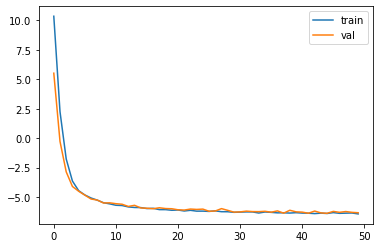

In [21]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Denoise with MCMC

In [22]:
from numpyro.infer import HMC, MixedHMC
from rnpe.denoise import spike_and_slab_denoiser
import matplotlib.pyplot as plt
from numpyro.infer import init_to_value

init = init_to_value(
    values={
        "x": data["x"][0],
        "misspecified": jnp.ones(len(data["y"]), int)
    }  
)

kernel = MixedHMC(
    HMC(
        spike_and_slab_denoiser,
        trajectory_length=1,
        init_strategy=init, target_accept_prob=0.95))
mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000)

key, mcmc_key = random.split(key)
model_args = [data["y"], flow]
mcmc.run(mcmc_key, *model_args)
mcmc.print_summary()


sample: 100%|██████████| 20000/20000 [00:51<00:00, 391.80it/s, 17 steps of size 6.84e-02. acc. prob=0.97]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
misspecified[0]      0.22      0.41      0.00      0.00      1.00    337.51      1.00
misspecified[1]      0.33      0.47      0.00      0.00      1.00    250.76      1.01
misspecified[2]      0.15      0.35      0.00      0.00      1.00    279.11      1.00
misspecified[3]      0.38      0.49      0.00      0.00      1.00    157.85      1.00
misspecified[4]      0.10      0.30      0.00      0.00      0.00    214.44      1.02
misspecified[5]      1.00      0.00      1.00      1.00      1.00       nan       nan
           x[0]     -0.85      0.04     -0.86     -0.89     -0.78    221.48      1.00
           x[1]     -0.78      0.09     -0.75     -0.96     -0.71    264.65      1.01
           x[2]     -0.13      0.03     -0.13     -0.17     -0.10    115.92      1.02
           x[3]     -0.79      0.11     -0.75     -0.99     -0.71    154.88      1.00
           x[4]     -0.46      0.03     -0.47     -0.

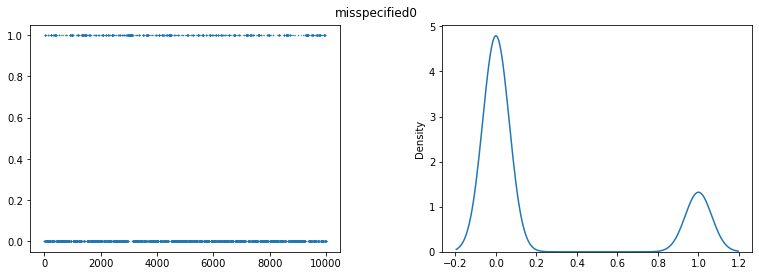

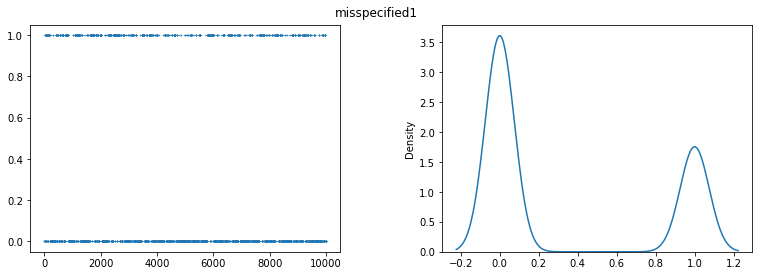

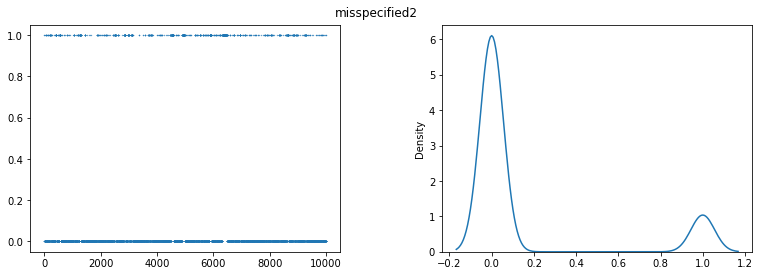

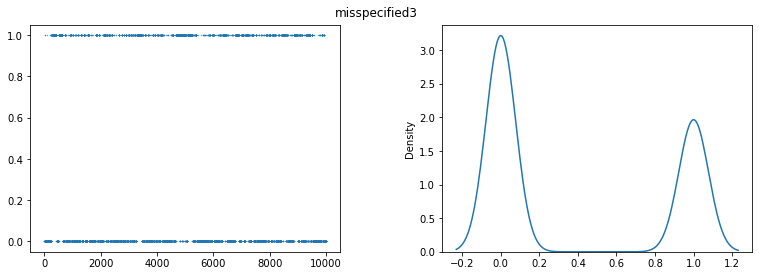

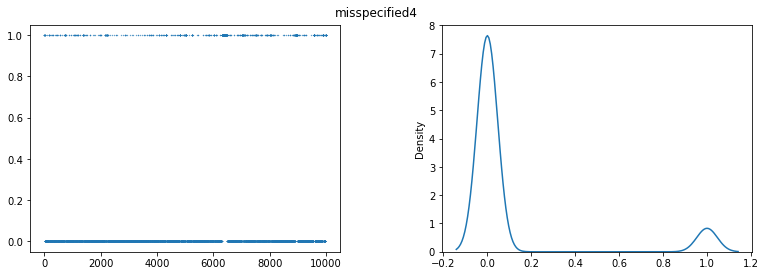

/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


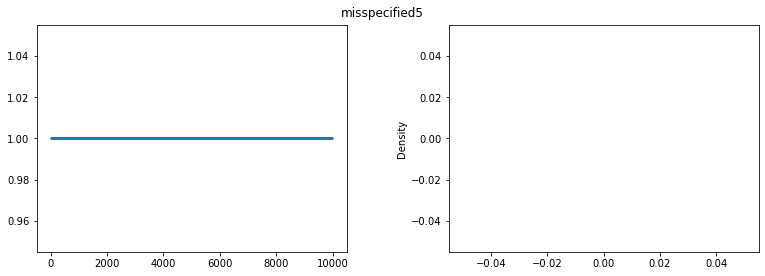

NameError: name 's' is not defined

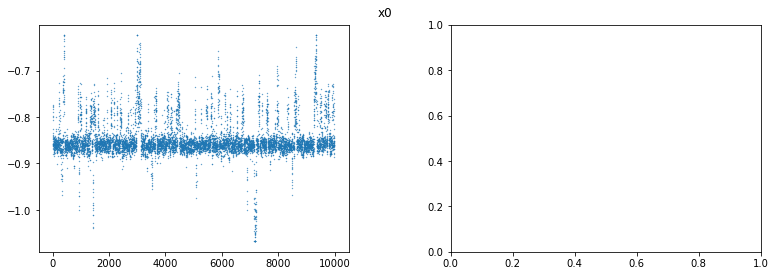

In [27]:
import pandas as pd

for sample_name, sample in mcmc.get_samples().items():
    sample = onp.array(sample)
    if sample.ndim == 1:
        sample = onp.expand_dims(sample, axis=1)  # to avoid iterating over items
    for i, col in enumerate(onp.transpose(sample)):
        if sample_name != "misspecified":
            col = onp.clip(col, jnp.quantile(col, 0.001), jnp.quantile(col, 0.999))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12, 4)
        fig.suptitle(sample_name + str(i))
        ax1.scatter(range(len(col)), col, s=0.1)

        if sample_name == "x":
            # Plot p(s) too
            df = pd.DataFrame({
                "x": onp.concatenate((col, data["x"][:, i])),
                "source": onp.repeat(["denoised", "marginal"], [len(col), len(s[:, i])])
            })

            sns.kdeplot(data=df, x="x", hue="source", ax=ax2, common_norm=False)
            ax2.axvline(data["y"][i].item(), color="tab:green")

        else:
            sns.kdeplot(col)
        plt.show()



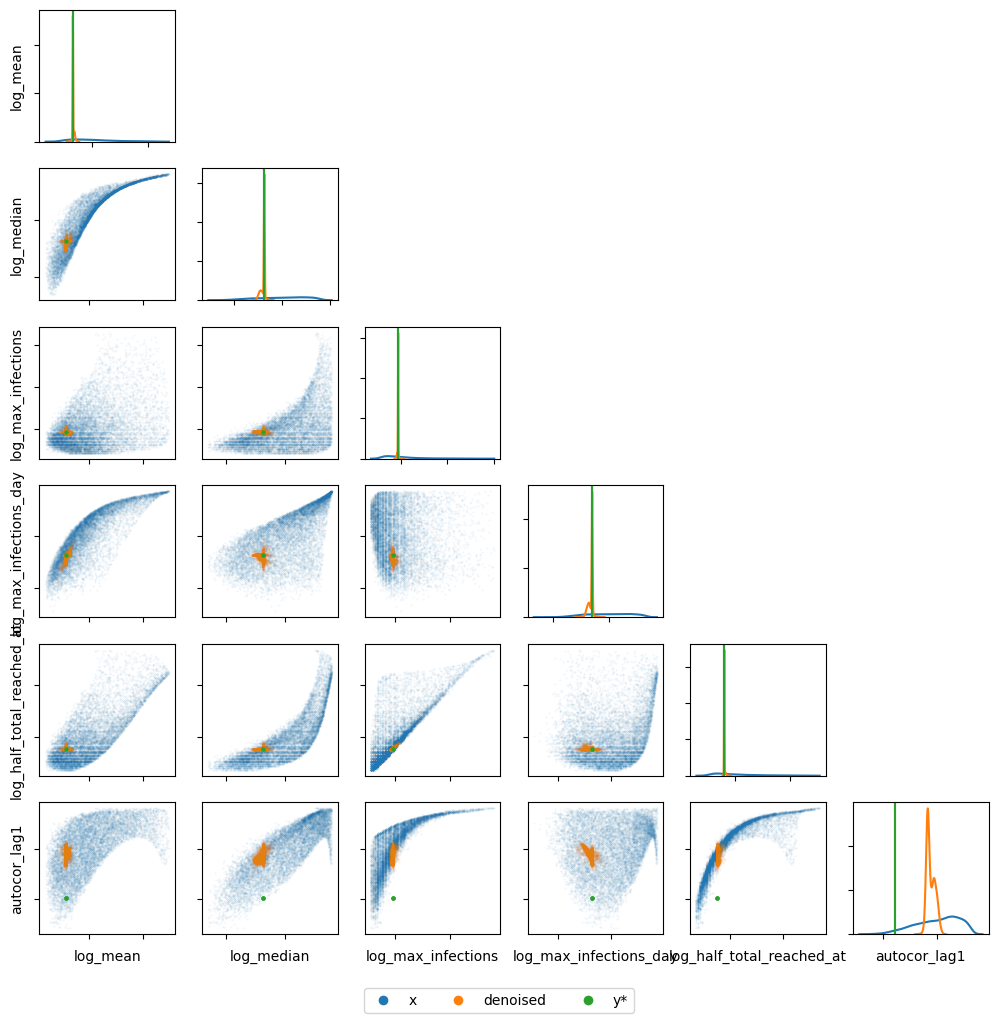

In [28]:
denoised = mcmc.get_samples()["x"]
pairplot((data["x"], denoised), data["y"], col_names=task.x_names, names=["x", "denoised", "y*"], legend_y_adjust=0.055, alpha=0.1)
# plt.savefig("plots/sirsde_denoised.png")

### Posterior inference

In [40]:
key, flow_key, train_key = random.split(key, 3)

posterior_flow = NeuralSplineFlow(
    flow_key,
    target_dim=data["theta"].shape[1],
    condition_dim=data["x"].shape[1])

posterior_flow, losses = train_flow(train_key, posterior_flow, data["theta"], data["x"], max_epochs=30, learning_rate=0.0005)


 73%|███████▎  | 22/30 [02:48<01:01,  7.66s/it, train=-4.29, val=-3.82]

Max patience reached.


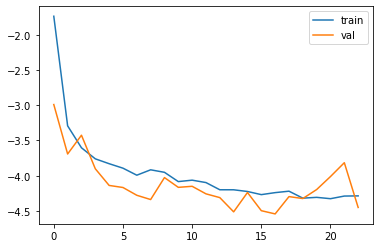

In [41]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Sample non-robust and robust posterior

In [35]:
robust_condition = mcmc.get_samples()["x"]
n_samples = robust_condition.shape[0]


In [36]:
key, subkey1, subkey2 = random.split(key, 3)

posteriors = {
    "prior": data["theta"][:n_samples],
    "robust": posterior_flow.sample(subkey1, robust_condition),
    "non_robust": posterior_flow.sample(subkey2, data["y"], n=n_samples),
}

posteriors = {k: onp.array(v) for k, v in posteriors.items()}
    

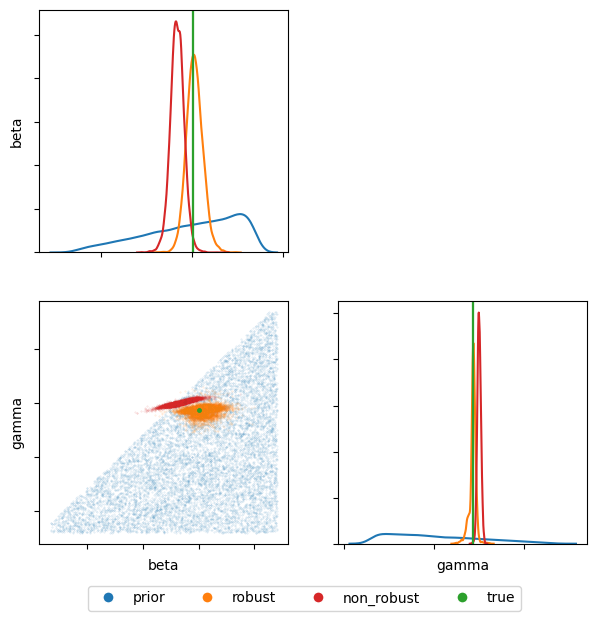

In [38]:
names = list(posteriors.keys()) + ["true"]
pairplot(list(posteriors.values()), data["theta_true"], col_names = ["beta", "gamma"], names=names, trim_quantile=5e-4)
plt.savefig("plots/sirsde_posterior.png")